<a href="https://colab.research.google.com/github/farhantandia/Machine-Learning-Practice/blob/master/Time_Series_Forecasting_using_Prophet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center>
<a href="http://bit.ly/algo-webinar-material" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
</center>

# Time Series Forecasting using Prophet (`fbprophet`)

<center>
<img src="https://img.evbuc.com/https%3A%2F%2Fcdn.evbuc.com%2Fimages%2F119018619%2F217108746850%2F1%2Foriginal.20201130-113000?w=720&auto=format%2Ccompress&q=75&sharp=10&rect=0%2C0%2C2160%2C1080&s=3e16f72b0a969ad9f16029450e8071ce" height="250">
</center>

The following coursebook is produced by the team at **Algoritma** for **BRI Data Hackathon 2021 Workshop: Data Science Report for Time Series Analysis**. The coursebook is intended for a restricted audience only, i.e. the individuals having received this coursebook directly from the training organization. It may not be reproduced, distributed, translated or adapted in any form outside these individuals and organizations without permission.

**Algoritma** is a data science education center based in Jakarta. We organize workshops and training programs to help working professionals and students gain mastery in various data science sub-fields: data visualization, machine learning, data modeling, statistical inference, etc.

---

# Preface

Before you go ahead and run the codes in this coursebook, it's often a good idea to go through some initial setup. Under the Training Objectives section we'll outline the syllabus, identify the key objectives and set up expectations for each module. Under the Libraries and Setup section you'll see some code to initialize our workspace and the libraries we'll be using for the projects. You may want to make sure that the libraries are installed beforehand by referring back to the packages listed here.

## Introduction

Time series data is one of the most common form of data to be found in every industry. It is considered to be a significant area of interest for most industries: retail, telecommunication, logistic, engineering, finance, and socio-economic. Time series analysis aims to extract the underlying components of a time series to better understand the nature of the data. In this workshop we will tackle a common industry case of business sales.

## Training Objectives

- Working with Time Series
  - Data Preprocessing
  - Visualization: Multiple vs Multivariate Time Series
- Modeling using `fbprophet`
  - Baseline Model
  - Trend Component
  - Seasonality Component
  - Holiday Effects
  - Adding Regressors
- Forecasting Evaluation
  - Train-Test Split
  - Evaluation Metrics: RMSLE
  - Expanding Window Cross Validation
- Hyperparameter Tuning

## Library and Setup

In this section you'll see some code to initialize our workspace, and the packages we'll be using for this project.

In [1]:
# data analysis
import numpy as np
import pandas as pd

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns

Since all local variables and files in Google Colab will be refreshed on each runtime, we'll run the code below to download the dataset from provided Google Drive ID. The downloaded file can be seen on Files menu.

In [2]:
# download dataset from Google Drive
!gdown --id 1KWrgTxR-Dq04NvPLr2YKNupG7wv9zmoR

Downloading...
From: https://drive.google.com/uc?id=1KWrgTxR-Dq04NvPLr2YKNupG7wv9zmoR
To: /content/sales_train.csv
94.6MB [00:00, 183MB/s]


---

# Data Loading

In this course, we will be using provided data from one of the largest Russian software firms - 1C Company and is made available through [Kaggle platform](https://www.kaggle.com/c/competitive-data-science-predict-future-sales/overview). This is a good example case of data since it contains seasonality and a particular 'noise' in several data when special occurences happened.

In [3]:
sales = pd.read_csv('sales_train.csv')
sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [4]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


Some insights we can get from the output are:

- The data consist of 2,935,849 observations (or rows)
- It has 6 variables (or columns)
- The following are the glossary provided in the Kaggle platform:
  - `date` is the date format provided in **dd.mm.yyyy** format
  - `date_block_num` is a consecutive month number used for convenience (January 2013 is 0, February 2013 is 1, and so on)
  - `shop_id` is the unique identifier of the shop
  - `item_id` is the unique identifier of the product
  - `item_price` is the price of the item on the specified date
  - `item_cnt_day` is the number of products sold on the specified date

The variable of interest that we are trying to predict is the **`item_cnt_day` and `item_price`**, which we'll see how to analyze the business demand from the sales record.

# Data Preprocessing

Time series data is defined as data observations that are collected at **regular time intervals**. In this case, we are talking about software sales **daily** data.

We have to make sure our data is ready to be fitted into models, such as:

- Convert `date` column data type from `object` to `datetime64`
- Sort the data ascending by `date` column
- Feature engineering of `total_revenue`, which will be forecasted

In [6]:
sales['date'] = pd.to_datetime(sales['date'], dayfirst=True)
sales.sort_values('date', inplace=True)
sales['total_revenue'] = sales['item_price'] * sales['item_cnt_day']

⚠️ The legal and cultural expectations for datetime format may vary between countries. In Indonesia for example, most people are used to storing dates in DMY order. `pandas` will infer date as a **month first** order by default. Since the sales `date` is stored in **dd.mm.yyyy** format, we have to specify parameter **`dayfirst=True`** inside `pd.to_datetime()` method.

Take a look on the third observation below; `pandas` converts it to 2nd January while the actual data represents February 1st.

In [7]:
date = pd.Series(['30-01-2021', '31-01-2021', '01-02-2021', '02-02-2021'])
pd.to_datetime(date) # yyyy-mm-dd

0   2021-01-30
1   2021-01-31
2   2021-01-02
3   2021-02-02
dtype: datetime64[ns]

Next, let's check the `date` range of `sales` data. Turns out it ranges from January 1st, 2013 to October 31st, 2015.

In [8]:
sales['date'].describe()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.


count                 2935849
unique                   1034
top       2013-12-28 00:00:00
freq                     9434
first     2013-01-01 00:00:00
last      2015-10-31 00:00:00
Name: date, dtype: object

We are interested in analyzing the most popular shop (`shop_id`) of our `sales` data. The popularity of a shop is defined by the number of transaction that occur. Let's create a frequency table using `.value_counts()` as follows:

In [9]:
top_3_shop = sales['shop_id'].value_counts().head(3)
top_3_shop

31    235636
25    186104
54    143480
Name: shop_id, dtype: int64

We have gain the information that **shop 31, 25, and 54** are the top three shops with the most record sales. Say we would like to analyze their time series attribute. To do that, we can apply **conditional subsetting** (filter) to `sales` data.

In [10]:
sales_top_3_shop = sales[sales['shop_id'].isin(top_3_shop.index)]
sales_top_3_shop.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,total_revenue
75872,2013-01-01,0,54,17111,149.0,1.0,149.0
81748,2013-01-01,0,54,1830,599.0,1.0,599.0
74642,2013-01-01,0,54,21565,349.0,1.0,349.0
81765,2013-01-01,0,54,1482,549.0,1.0,549.0
86487,2013-01-01,0,54,7945,13990.0,1.0,13990.0


Now let’s highlight again the most important definition of a time series: it is **an observation** that is recorded at a regular time interval. Notice that the records has a multiple samples of the same day. This must mean that our data frame violates the rules of a time series where the records is sampled multiple time a day. Based on the structure of our data, it is recording the sales of different items within the same day. An important aspect in preparing a time series is called a **data aggregation**, where we need to aggregate the sales from one day into one records. Now let’s take a look at the codes:

In [11]:
daily_sales = sales_top_3_shop.groupby(['date', 'shop_id']) \
                [['item_cnt_day', 'total_revenue']] \
                .sum().reset_index() \
                .rename(columns={'item_cnt_day': 'total_qty'})
daily_sales.head()

,date,shop_id,total_qty,total_revenue
0,2013-01-01,54,415.0,316557.00
1,2013-01-02,25,568.0,345174.13
2,2013-01-02,31,568.0,396376.10
3,2013-01-02,54,709.0,519336.00
4,2013-01-03,25,375.0,249421.00


Note that in performing data aggregation, we can only transform a more frequent data sampling to a more sparse frequency, for example:

- Hourly to daily
- Daily to weekly
- Daily to monthly
- Monthly to quarterly, and so on

---

# Visualization

One of an important aspect in time series analysis is performing a visual exploratory analysis. Python is known for its graphical capabilities and has a very popular visualization package called **`matplotlib` and `seaborn`**. Let’s take our `daily_sales` data frame we have created earlier and observe through the visualization.

⚠️ There is a misconception between multiple and multivariate time series. Here are the definitions for each term:

- Multiple time series: There is **one variable** from **multiple objects** being observed from time to time.

- Multivariate Time series: There are **multiple variables** from only **one object** being observed from time to time. Typically for such series, the variables are closely interrelated.

## Multiple Time Series

In our case, multiple time series is when we observed the fluctuation of `total_qty` over time, from the top three shops.

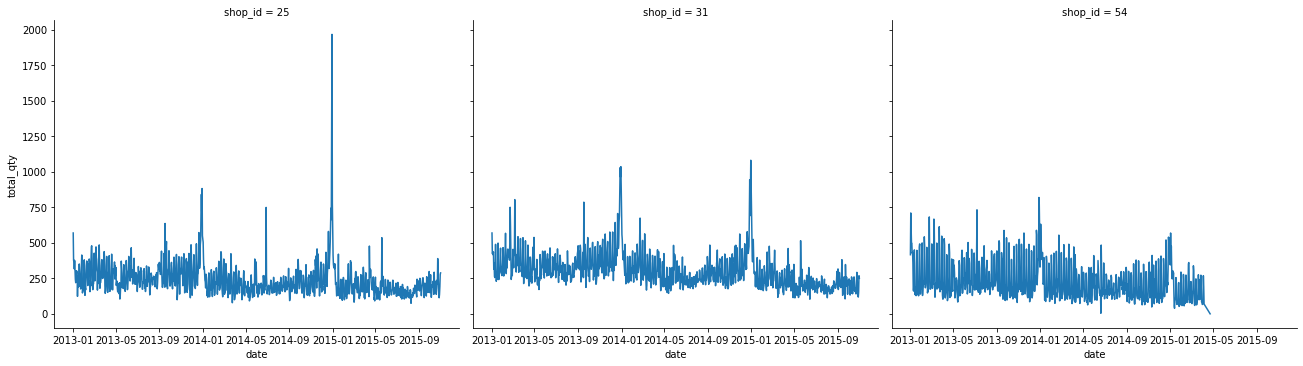

In [12]:
sns.relplot(data=daily_sales, kind='line',
            x='date', y='total_qty', col='shop_id', aspect=6/5)
plt.show()

From the visualization we can conclude that the fluctuation of `total_qty` is very distinct for each shop. There are some extreme spikes on `shop_id` 25 and 31 at the end of each year, while `shop_id` 54 doesn't have any spike. 

## Multivariate Time Series

In our case, multivariate time series is when we observed the fluctuation of `total_qty` and `total_revenue` over time, from only `shop_id` 31. Notice that we perform conditional subsetting on `daily_sales` to produce `daily_sales_31`.

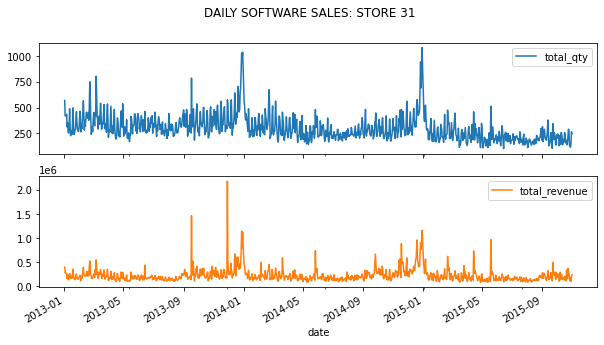

In [14]:
daily_sales_31 = daily_sales[daily_sales['shop_id'] == 31].reset_index(drop=True)
daily_sales_31.set_index('date')[['total_qty', 'total_revenue']].plot(subplots=True,
                                                                      figsize=(10, 5))
plt.suptitle('DAILY SOFTWARE SALES: STORE 31')
plt.show()

From the visualization we can conclude that the fluctuation of `total_qty` and `total_revenue` is quite similar for `shop_id` 31. In fact, from the business perspective, variable quantity and revenue are closely related to each other. When the `total_qty` sold increases, logically, the `total_revenue` will also increases.

# Modeling using `fbprophet`

A very fundamental part in understanding time series is to be able to **decompose** its underlying components. A classic way in describing a time series is using **General Additive Model (GAM)**. This definition describes time series as a summation of its components. As a starter, we will define time series with 3 different components:

- Trend ($T$): Long term movement in its mean
- Seasonality ($S$): Repeated seasonal effects
- Residuals ($E$): Irregular components or random fluctuations not described by trend and seasonality

The idea of GAM is that each of them is added to describe our time series:

$Y(t) = T(t) + S(t) + E(t)$

When we are discussing time series forecasting there is one main assumption that needs to be remembered: **We assume correlation among successive observations**. Means that the idea of performing a forecasting for a time series is based on its past behavior. So in order to forecast the future values, we will take a look at any existing trend and seasonality of the time series and use it to generate future values.

Prophet enhanced the classical trend and seasonality components by adding a **holiday effect**. It will try to model the effects of holidays which occur on some dates and has been proven to be really useful in many cases. Take, for example: Lebaran Season. In Indonesia, it is really common to have an effect on Lebaran season. The effect, however, is a bit different from a classic seasonality effect because it shows the characteristics of an **irregular schedule**.

## Baseline Model

### Prepare the data

To use the `fbprophet` package, we first need to prepare our time series data into a specific format data frame required by the package. The data frame requires 2 columns:

- `ds`: the time stamp column, stored in `datetime64` data type
- `y`: the value to be forecasted

In this example, we will be using the `total_qty` as the value to be forecasted.

In [15]:
daily_total_qty = daily_sales_31[['date', 'total_qty']].rename(
    columns={'date': 'ds',
             'total_qty': 'y'})

daily_total_qty.head()

,ds,y
0,2013-01-02,568.0
1,2013-01-03,423.0
2,2013-01-04,431.0
3,2013-01-05,415.0
4,2013-01-06,435.0


### Fitting Model

Let’s initiate a `fbprophet` object using `Prophet()` and fit the `daily_total_qty` data. The idea of fitting a time series model is to extract the pattern information of a time series in order to perform a forecasting over the specified period of time.

In [ ]:
from fbprophet import Prophet
model_31 = Prophet()
model_31.fit(daily_total_qty)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


### Forecasting

Based on the existing data, we'd like to perform a forecasting for **1 years into the future**. To do that, we will need to first prepare a data frame that consist of the future time stamp range we'd like to forecast. Luckily, `fbprophet` has provided `.make_future_dataframe()` method that help us to prepare the data:

In [ ]:
future_31 = model_31.make_future_dataframe(periods=365, freq='D')
future_31.tail()

,ds
1391,2016-10-26
1392,2016-10-27
1393,2016-10-28
1394,2016-10-29
1395,2016-10-30


Now we have acquired a new `future_31` data frame that consist of a date span of **the beginning of a time series to 365 days into the future**. We will then use this data frame is to perform the forecasting by using `.predict()` method of our `model_31`:

In [ ]:
forecast_31 = model_31.predict(future_31)
forecast_31[['ds', 'trend', 'weekly', 'yearly', 'yhat']]

,ds,trend,weekly,yearly,yhat
0,2013-01-02,376.014905,-32.833816,234.600919,577.782008
1,2013-01-03,375.942465,-26.061642,215.077487,564.958311
2,2013-01-04,375.870026,55.637544,193.971274,625.478844
3,2013-01-05,375.797587,82.002893,171.625948,629.426428
4,2013-01-06,375.725148,-2.450713,148.403261,521.677695
...,...,...,...,...,...
1391,2016-10-26,153.726469,-32.833816,-32.499417,88.393237
1392,2016-10-27,153.545641,-26.061642,-30.534326,96.949673
1393,2016-10-28,153.364812,55.637544,-27.645116,181.357241
1394,2016-10-29,153.183984,82.002893,-23.842381,211.344496


Recall that in General Additive Model, we use time series components and perform a summation of all components. In this case, we can see that the model is extracting 3 types of components: `trend`, `weekly` seasonality, and `yearly` seasonality. Means, in forecasting future values it will use the following formula:

$yhat(t) = T(t) + S_{weekly}(t) + S_{yearly}(t)$

We can manually confirm from `forecast_31` that the column `yhat` = `trend` + `weekly` + `yearly`.

In [ ]:
forecast_31['trend'] + forecast_31['weekly'] + forecast_31['yearly']

0       577.782008
1       564.958311
2       625.478844
3       629.426428
4       521.677695
           ...    
1391     88.393237
1392     96.949673
1393    181.357241
1394    211.344496
1395    131.390064
Length: 1396, dtype: float64

In [ ]:
forecast_31['yhat']

0       577.782008
1       564.958311
2       625.478844
3       629.426428
4       521.677695
           ...    
1391     88.393237
1392     96.949673
1393    181.357241
1394    211.344496
1395    131.390064
Name: yhat, Length: 1396, dtype: float64

### Visualize

Now, observe how `.plot()` method take our model_31, and newly created forecast_31 object to create a `matplotlib` object that shows the forecasting result. The black points in the plot shows the **actual** time series, and the blue line shows the **fitted** time series along with its forecasted values 365 days into the future.

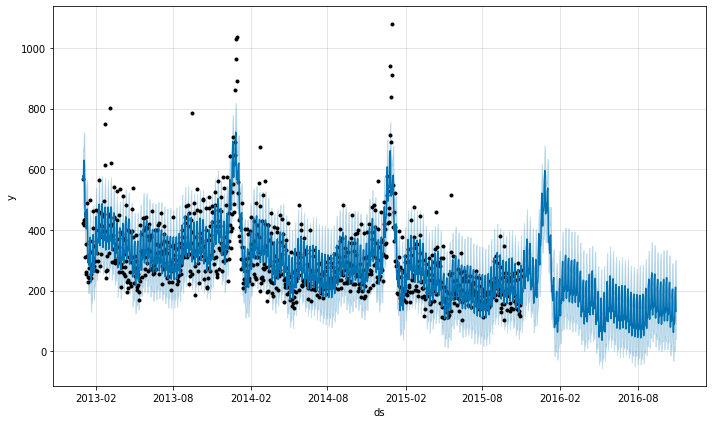

In [ ]:
fig = model_31.plot(forecast_31)

We can also visualize each of the trend and seasonality components using `.plot_components` method.

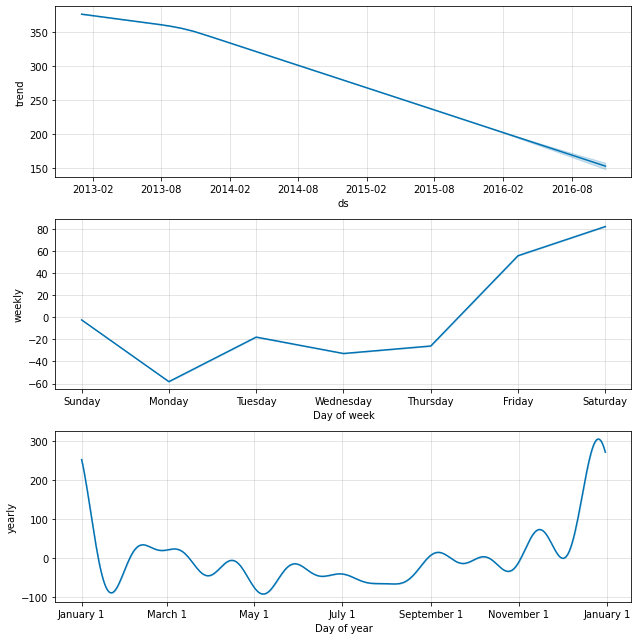

In [ ]:
fig = model_31.plot_components(forecast_31)

From the visualization above, we can get insights such as:

- The trend shows that the `total_qty` sold is decreasing from time to time.
- The weekly seasonality shows that sales on weekends are higher than weekdays.
- The yearly seasonality shows that sales peaked at the end of the year.

#### [Optional] Interactive Visualization

An interactive figure of the forecast and components can be created with `plotly`. You will need to install `plotly` 4.0 or above separately, as it will not by default be installed with `fbprophet`. You will also need to install the `notebook` and `ipywidgets` packages.

In [ ]:
import plotly.io as pio
pio.renderers.default = 'colab'

In [ ]:
from fbprophet.plot import plot_plotly, plot_components_plotly
plot_plotly(model_31, forecast_31)

In [ ]:
plot_components_plotly(model_31, forecast_31)

## Trend Component

The trend components of our model, as plotted using `.plot_components()` method is producing a decreasing trend over the year. Trend is defined as a long term movement of average over the year. The methods that is implemented by Prophet is by default a **linear model** as shown below:

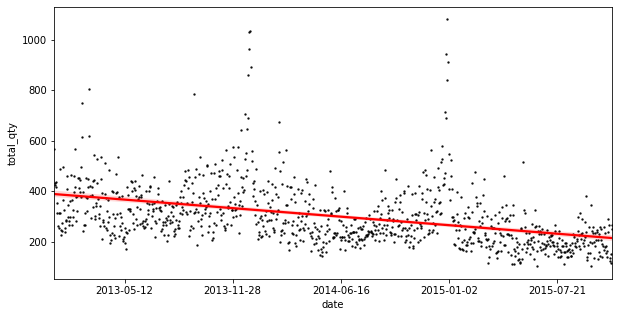

In [ ]:
#@title
# for illustration purposes only
from datetime import date

## prepare data
daily_sales_31_copy = daily_sales_31.copy()
daily_sales_31_copy['date_ordinal'] = daily_sales_31_copy['date'].apply(lambda date: date.toordinal())

## visualize regression line
plt.figure(figsize=(10, 5))
ax = sns.regplot(x='date_ordinal', y='total_qty', data=daily_sales_31_copy,
            scatter_kws={'color': 'black', 's': 2},
            line_kws={'color': 'red'})
new_labels = [date.fromordinal(int(item)) for item in ax.get_xticks()]
ax.set_xticklabels(new_labels)
plt.xlabel('date')
plt.show()

### Automatic Changepoint Detection

Prophet however implements a changepoint detection which tries to automatically detect a point where the slope has a significant change rate. It will tries to split the series using several points where the trend slope is calculated for each range.

By default, `prophet` specifies 25 potential changepoints (`n_changepoints=25`) which are placed uniformly on the first 80% of the time series (`changepoint_range=0.8`).

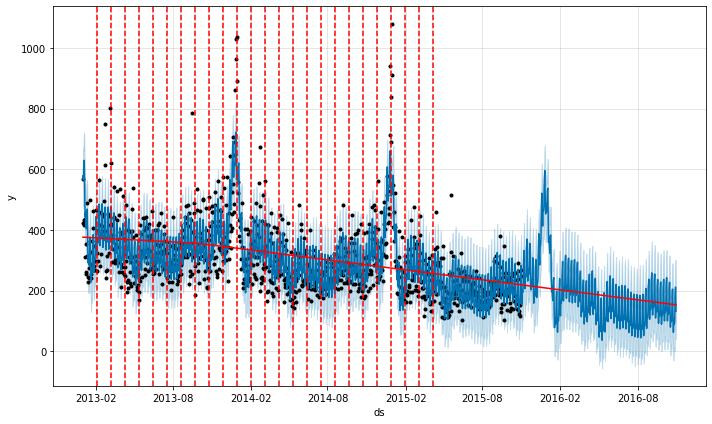

In [ ]:
#@title
# for illustration purposes only, threshold = 0
from fbprophet.plot import add_changepoints_to_plot
fig = model_31.plot(forecast_31)
a = add_changepoints_to_plot(fig.gca(), model_31, forecast_31, threshold=0)

From the 25 potential changepoints, it will then calculate the magnitude of the slope change rate and decided the **significant** change rate. The model detected **3 significant changepoints** and separate the series into **4 different trend slopes**.

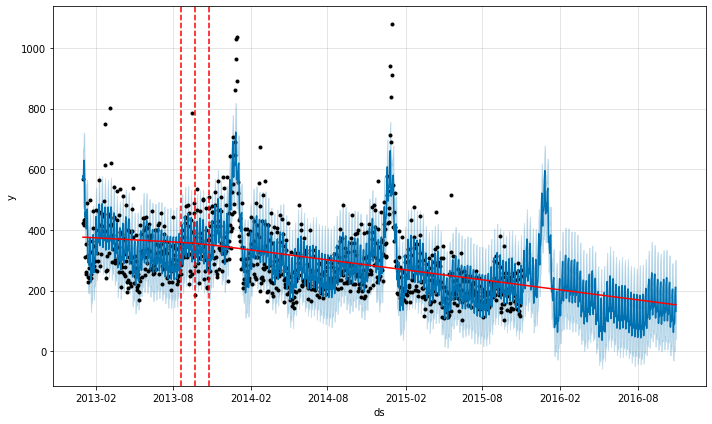

In [ ]:
fig = model_31.plot(forecast_31)
a = add_changepoints_to_plot(fig.gca(), model_31, forecast_31)

### Adjusting Trend Flexibility

Prophet provided us a tuning parameter to adjust the detection flexibility:

- `n_changepoints` (default = 25): The number of potential changepoints, **not recommended** to be tuned, this is better tuned by adjusting the regularization (`changepoint_prior_scale`)
- `changepoint_range` (default = 0.8): Proportion of the history in which the trend is allowed to change. Recommended range: [0.8, 0.95]
- `changepoint_prior_scale` (default = 0.05): The flexibility of the trend, and in particular how much the trend changes at the trend changepoints. Recommended range: [0.001, 0.5]

💡 Increasing the default value of the parameter above will give extra flexibility to the trend line (overfitting the training data). On the other hand, decreasing the value will cause the trend to be less flexible (underfitting).

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


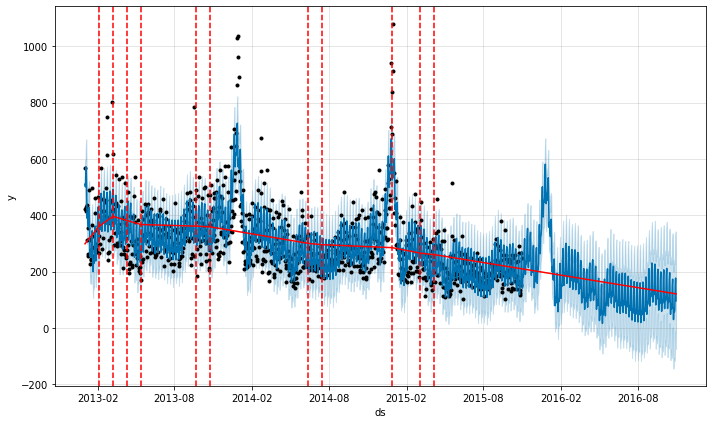

In [ ]:
# fitting model
model_tuning_trend = Prophet(
    n_changepoints=25, # default = 25
    changepoint_range=0.8, # default = 0.8
    changepoint_prior_scale=0.5 # default = 0.05
    )
model_tuning_trend.fit(daily_total_qty)

# forecasting
future = model_tuning_trend.make_future_dataframe(periods=365, freq='D')
forecast = model_tuning_trend.predict(future)

# visualize
fig = model_tuning_trend.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), model_tuning_trend, forecast)

## Seasonality Component

Let’s talk about other time series component, seasonality. We will review the following plot components.

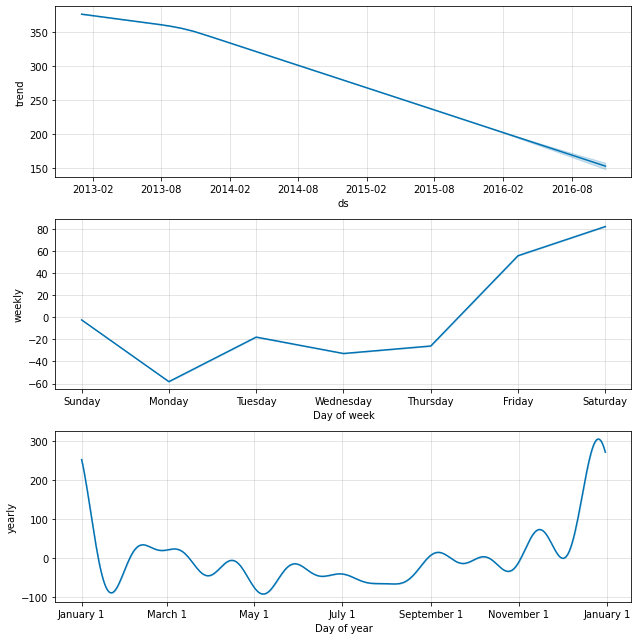

In [ ]:
fig = model_31.plot_components(forecast_31)

By default, Prophet will try to determine existing seasonality based on existing data provided. In our case, the data provided is a **daily** data from early 2013 to end 2015.

- Any daily sampled data by default will be detected to have a **weekly seasonality**.
- While **yearly seasonality**, by default will be set as `True` if the provided data has more than 2 years of daily sample.
- The other regular seasonality is a **daily seasonality** which tries to model an hourly pattern of a time series. Since our data does not accommodate hourly data, by default the daily seasonality will be set as `False`.

### Fourier Order

Prophet uses a Fourier series to approximate the seasonality effect. It is a way of approximating a periodic function as a (possibly infinite) **sum of sine and cosine** functions. 

💡 The number of terms in the partial sum (the order) is a parameter that determines how quickly the seasonality can change. Increasing the fourier order will give extra flexibility to the seasonality (overfitting the training data), and vice versa.

Here is an interactive introduction to Fourier: http://www.jezzamon.com/fourier/

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


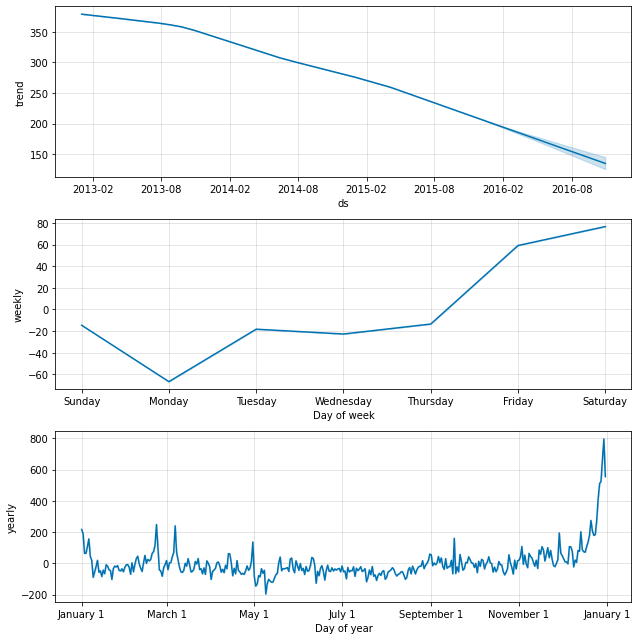

In [ ]:
# fitting model
model_tuning_seasonality = Prophet(
    weekly_seasonality=3, # default = 3
    yearly_seasonality=200 # default = 10
    )
model_tuning_seasonality.fit(daily_total_qty)

# forecasting
future = model_tuning_seasonality.make_future_dataframe(periods=365, freq='D')
forecast = model_tuning_seasonality.predict(future)

# visualize
fig = model_tuning_seasonality.plot_components(forecast)

### Custom Seasonalities

The default provided seasonality modelled by Prophet for a daily sampled data is: weekly and yearly. 

Consider this case: a sales in your business is heavily affected by payday. Most customers tends to buy your product based on the day of the month. Since it did not follow the default seasonality of yearly and weekly, we will need to define a non-regular seasonality. There are two steps we have to do:
1. Remove default seasonality (eg: remove yearly seasonality) by setting `False`
2. Add seasonality (eg: add monthly seasonality) by using `.add_seasonality()` method before fitting the model

We ended up with formula:
$yhat(t) = T(t) + S_{weekly}(t) + \bf{S_{monthly}(t)}$

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


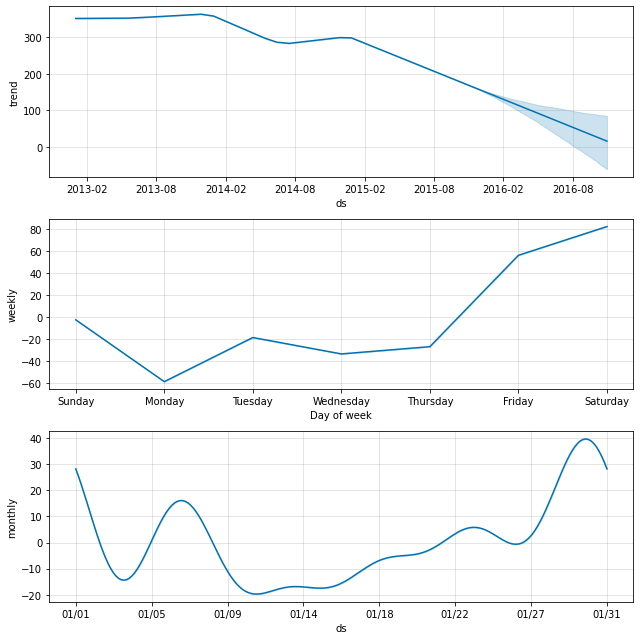

In [ ]:
# fitting model
model_custom_seasonality = Prophet(
    yearly_seasonality=False ## remove seasonality
    )
## add seasonality
model_custom_seasonality.add_seasonality(name='monthly', period=30.5, fourier_order=5)
model_custom_seasonality.fit(daily_total_qty)

# forecasting
future = model_custom_seasonality.make_future_dataframe(periods=365, freq='D')
forecast = model_custom_seasonality.predict(future)

# visualize
fig = model_custom_seasonality.plot_components(forecast)

For monthly seasonality, we provided period = 30.5 indicating that there will be non-regular 30.5 frequency in one season of the data. The 30.5 is a common frequency quantifier for monthly seasonality, since there are some months with a total of 30 and 31 (some are 28 or 29).

💡 Recommended Fourier order according to the seasonality:
- weekly seasonality = 3
- monthly seasonality = 5
- yearly seasonality = 10

## Holiday Effects

One of the advantage in using Prophet is the ability to model a holiday effect. This holiday effect is defined as a non-regular effect that needs to be **manually** specified by the user.

### Modeling Holidays and Special Events

Now let’s take a better look for our data. We could see that **every end of a year**, there is a significant increase of sales which exceeds 800 sales a day.

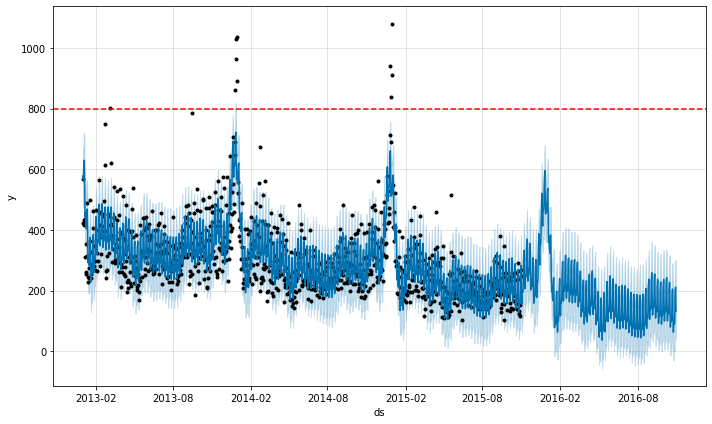

In [ ]:
#@title
# for illustration purposes only
fig = model_31.plot(forecast_31)
plt.axhline(y=800, color='red', ls='--')
plt.show()

Table below shows that the relatively large sales mostly happened at the very end of a year between **27th to 31st** December. Now let’s assume that this phenomenon is the result of the **new year eve** where most people spent the remaining budget of their Christmas or End year bonus to buy our goods.

In [ ]:
daily_total_qty[daily_total_qty['y'] > 800]

,ds,y
64,2013-03-07,803.0
359,2013-12-27,861.0
360,2013-12-28,1028.0
361,2013-12-29,962.0
362,2013-12-30,1035.0
363,2013-12-31,891.0
723,2014-12-27,942.0
725,2014-12-29,839.0
726,2014-12-30,1080.0
727,2014-12-31,912.0


We'll need to prepare a `holiday` data frame with the following column:

- `holiday`: the holiday unique name identifier
- `ds`: timestamp
- `lower_window`: how many time unit **behind** the holiday that is assumed to to be affected (smaller or equal than zero)
- `upper_window`: how many time unit **after** the holiday that is assumed to be affected (larger or equal to zero)

⚠️ It must include all occurrences of the holiday, both in the **past** (back as far as the historical data go) and in the **future** (out as far as the forecast is being made).

In [ ]:
holiday = pd.DataFrame({
    'holiday': 'new_year_eve',
    'ds': pd.to_datetime(['2013-12-31', '2014-12-31', # past date, historical data 
                          '2015-12-31']), # future date, to be forecasted
    'lower_window': -4, # include 27th - 31st December
    'upper_window': 0})
holiday

,holiday,ds,lower_window,upper_window
0,new_year_eve,2013-12-31,-4,0
1,new_year_eve,2014-12-31,-4,0
2,new_year_eve,2015-12-31,-4,0


Once we have prepared our `holiday` data frame, we can pass that into the `Prophet()` class:

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


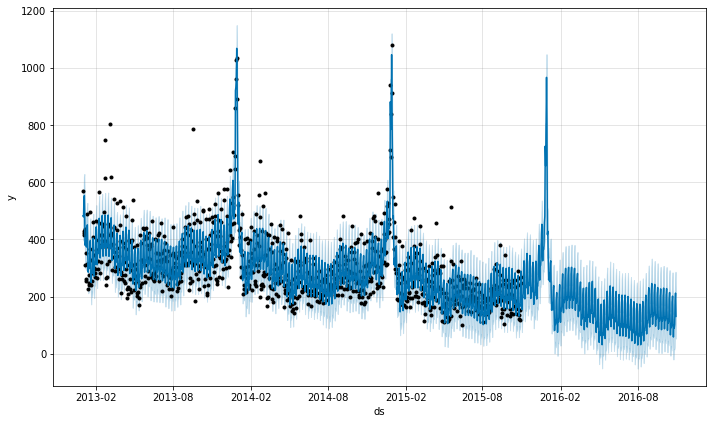

In [ ]:
# fitting model
model_holiday = Prophet(holidays=holiday)
model_holiday.fit(daily_total_qty)

# forecasting
future = model_holiday.make_future_dataframe(periods=365, freq='D')
forecast = model_holiday.predict(future)

# visualize
fig = model_holiday.plot(forecast)

Observe how now it has more confidence in capturing the holiday effect on the end of the year instead of relying on the yearly seasonality effect. If we plot the components, we could also get the holiday components listed as one of the time series components:

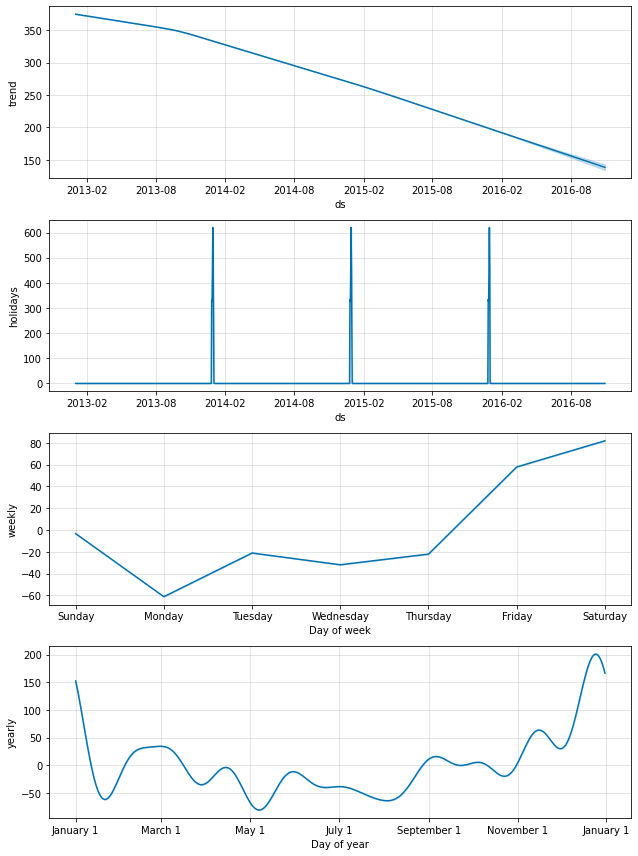

In [ ]:
fig = model_holiday.plot_components(forecast)

### Built-in Country Holidays

We can use a built-in collection of country-specific holidays using the `.add_country_holidays()` method before fitting model. For Indonesia, we can specify parameter `country_name='ID'`.

In [ ]:
model_holiday_indo = Prophet()
model_holiday_indo.add_country_holidays(country_name='ID')
model_holiday_indo.fit(daily_total_qty)

model_holiday_indo.train_holiday_names

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/usr/local/lib/python3.6/dist-packages/fbprophet/hdays.py:105: Warning:

We only support Nyepi holiday from 2009 to 2019



0               New Year's Day
1             Chinese New Year
2        Day of Silence/ Nyepi
3     Ascension of the Prophet
4                    Labor Day
5           Ascension of Jesus
6            Buddha's Birthday
7                  Eid al-Fitr
8             Independence Day
9       Feast of the Sacrifice
10            Islamic New Year
11                   Christmas
12        Birth of the Prophet
dtype: object

💡 We can also manually populate Indonesia holiday by using `hdays` module. This is useful if we want to take a look on the holiday dates and then manually include only certain holidays.

In [ ]:
# for illustration purposes only
# Reference: https://github.com/facebook/prophet/blob/master/python/fbprophet/hdays.py
from fbprophet import hdays
holidays_indo = hdays.Indonesia()
holidays_indo._populate(2020)
holidays_indo._populate(2021)
pd.DataFrame([holidays_indo], index=['holiday']).T.rename_axis('ds').reset_index()

/usr/local/lib/python3.6/dist-packages/fbprophet/hdays.py:105: Warning:

We only support Nyepi holiday from 2009 to 2019



,ds,holiday
0,2020-01-01,New Year's Day
1,2020-01-25,Chinese New Year
2,2020-03-22,Ascension of the Prophet
3,2020-05-01,Labor Day
4,2020-05-21,Ascension of Jesus
5,2020-05-07,Buddha's Birthday
6,2020-06-01,Pancasila Day
7,2020-05-25,Eid al-Fitr
8,2020-08-17,Independence Day
9,2020-08-20,Islamic New Year


## Adding Regressors

Additional regressors can be added to the linear part of the model using the `.add_regressor()` method, before fitting model. In this case, we want to forecast `total_revenue` based on its previous revenue components (trend, seasonality, holiday) and also `total_qty` sold as the regressor:

$revenue(t) = T_{revenue}(t) + S_{revenue}(t) + H_{revenue}(t) + \bf{qty(t)}$

⚠️ The extra regressor must be known for both the **history** and for **future** dates. It thus must either be something that has known future values or something that has separately been forecasted with a time series model, such as Prophet. A note of **caution** around this approach: error in the forecast of regressor will produce error in the forecast of target value.



In [ ]:
daily_sales_31.head()

,date,shop_id,total_qty,total_revenue
0,2013-01-02,31,568.0,396376.10
1,2013-01-03,31,423.0,276933.11
2,2013-01-04,31,431.0,286408.00
3,2013-01-05,31,415.0,273245.00
4,2013-01-06,31,435.0,260775.00


### Forecast the Regressor (`total_qty`)

In this section, we separately create a Prophet model to forecast `total_qty`, before we forecast `total_revenue`.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


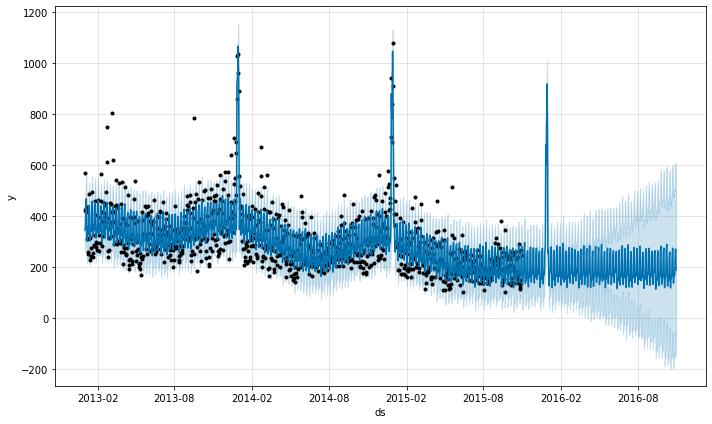

In [ ]:
# fitting model
model_total_qty = Prophet(
    n_changepoints=20, # trend flexibility
    changepoint_range=0.9, # trend flexibility
    changepoint_prior_scale=0.25, # trend flexibility
    weekly_seasonality=5, # seasonality fourier order
    yearly_seasonality=False, # remove seasonality
    holidays=holiday # new year eve effects
    )
## add monthly seasonality
model_total_qty.add_seasonality(name='monthly', period=30.5, fourier_order=5)
model_total_qty.fit(daily_total_qty)

# forecasting
future = model_total_qty.make_future_dataframe(periods=365, freq='D')
forecast_total_qty = model_total_qty.predict(future)

# visualize
fig = model_total_qty.plot(forecast_total_qty)

The table below shows the forecasted total quantity for the last 365 days (from November 1st, 2015 until October 30th, 2016).

In [ ]:
forecasted_total_qty = forecast_total_qty[['ds', 'yhat']].tail(365) \
                        .rename(columns={'yhat': 'total_qty'})
forecasted_total_qty

,ds,total_qty
1031,2015-11-01,193.255929
1032,2015-11-02,128.734150
1033,2015-11-03,164.798473
1034,2015-11-04,158.194736
1035,2015-11-05,178.743638
...,...,...
1391,2016-10-26,165.831597
1392,2016-10-27,171.156393
1393,2016-10-28,247.616489
1394,2016-10-29,271.470601


On the other hand, the table below shows the actual total quantity which we used for training model. We have to rename the column exactly like the previous table.

In [ ]:
actual_total_qty = daily_total_qty.rename(columns={'y': 'total_qty'})
actual_total_qty

,ds,total_qty
0,2013-01-02,568.0
1,2013-01-03,423.0
2,2013-01-04,431.0
3,2013-01-05,415.0
4,2013-01-06,435.0
...,...,...
1026,2015-10-27,123.0
1027,2015-10-28,117.0
1028,2015-10-29,152.0
1029,2015-10-30,267.0


Now, we have to prepare concatenated data of `total_qty` as the regressor values of `total_revenue`:

- First 1031 observations: actual values of `total_qty`
- Last 365 observations: forecasted values of `total_qty`

In [ ]:
future_with_regressor = pd.concat([actual_total_qty, forecasted_total_qty])
future_with_regressor

,ds,total_qty
0,2013-01-02,568.000000
1,2013-01-03,423.000000
2,2013-01-04,431.000000
3,2013-01-05,415.000000
4,2013-01-06,435.000000
...,...,...
1391,2016-10-26,165.831597
1392,2016-10-27,171.156393
1393,2016-10-28,247.616489
1394,2016-10-29,271.470601


### Forecast the Target Variable (`total_revenue`)

Next, we create a Prophet model to forecast `total_revenue`, using `total_qty` as the regressor. Make sure to rename the date as `ds` and the value to be forecasted as `y`.

In [ ]:
daily_total_revenue = daily_sales_31[['date', 'total_revenue', 'total_qty']].rename(
    columns={'date': 'ds',
             'total_revenue': 'y'})

daily_total_revenue.head()

,ds,y,total_qty
0,2013-01-02,396376.10,568.0
1,2013-01-03,276933.11,423.0
2,2013-01-04,286408.00,431.0
3,2013-01-05,273245.00,415.0
4,2013-01-06,260775.00,435.0


During fitting a model with regressor, make sure:
- Apply `.add_regressor()` method before fitting
- Forecast the value using `future_with_regressor` data frame that we have prepared before, containing `ds` and the regressor values

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


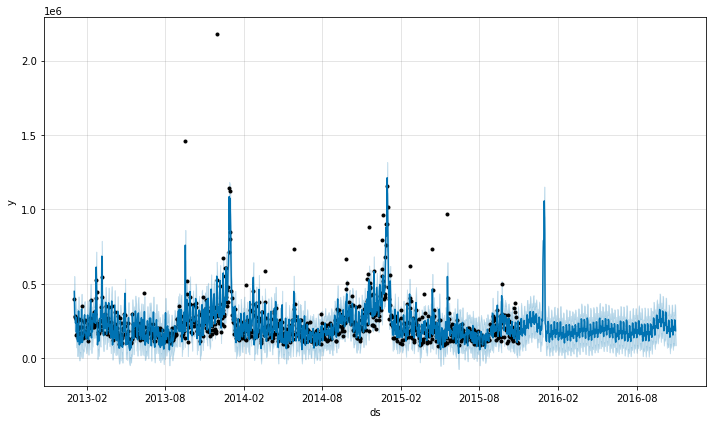

In [ ]:
# fitting model
model_total_revenue = Prophet(
    holidays=holiday # new year eve effects
    )
## add regressor
model_total_revenue.add_regressor('total_qty')
model_total_revenue.fit(daily_total_revenue)

# forecasting
## use dataframe with regressor, instead of just `ds` column
forecast_total_revenue = model_total_revenue.predict(future_with_regressor)

# visualize
fig = model_total_revenue.plot(forecast_total_revenue)

If we plot the components, we could also get the extra regressors components listed as one of the time series components:

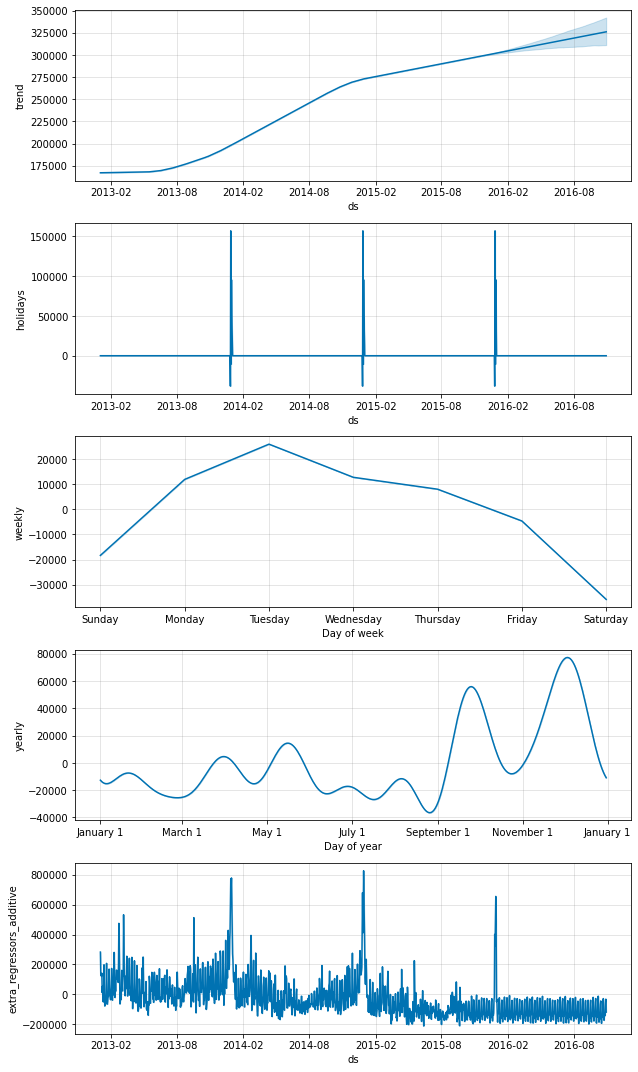

In [ ]:
fig = model_total_revenue.plot_components(forecast_total_revenue)

⚠️ By adding regressors, we lose the ability to interpret the other components (trend, seasonality, holiday) due to the fluctuation of the extra regressor value.

# Forecasting Evaluation

Recall how we performed a visual analysis on how the performance of our forecasting model earlier. The technique was in fact, a widely used technique for model cross-validation. It involves splitting our data into two parts:

- Train data is used to train our time series model in order to acquire the underlying patterns such as trend and seasonality.
- Test data is purposely being kept for us to perform a cross-validation and see how our model perform on an **unseen data**.

The objective is quite clear, is that we are able to acquire a glimpse of what kind of error are we going to expect for the model.

## Train-Test Split

Recall that our data has the range of early 2013 to end 2015. Say, we are going to save the records of 2015 as a test data and use the rest for model training. The points in red will now be treated as unseen data and will not be passed in to our Prophet model.

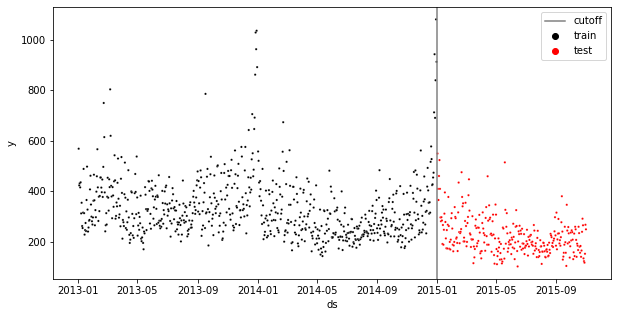

In [ ]:
#@title
# for illustration purposes only
cutoff = pd.to_datetime('2015-01-01')
daily_total_qty['type'] = daily_total_qty['ds'].apply(
    lambda date: 'train' if date < cutoff else 'test')

plt.figure(figsize=(10, 5))
sns.scatterplot(x='ds', y='y', hue='type', s=5,
                palette=['black', 'red'],
                data=daily_total_qty)
plt.axvline(x=cutoff, color='gray', label='cutoff')
plt.legend()
plt.show()



We can split at a cutoff using conditional subsetting as below:

In [ ]:
train = daily_total_qty[daily_total_qty['ds'] < cutoff]
test = daily_total_qty[daily_total_qty['ds'] >= cutoff]

print(f'Train size: {train.shape}')
print(f'Test size: {test.shape}')

Train size: (728, 3)
Test size: (303, 3)


Now let's train the model using data from 2013-2014 only, and forecast **303 days** into the future (until October 31st, 2015).

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


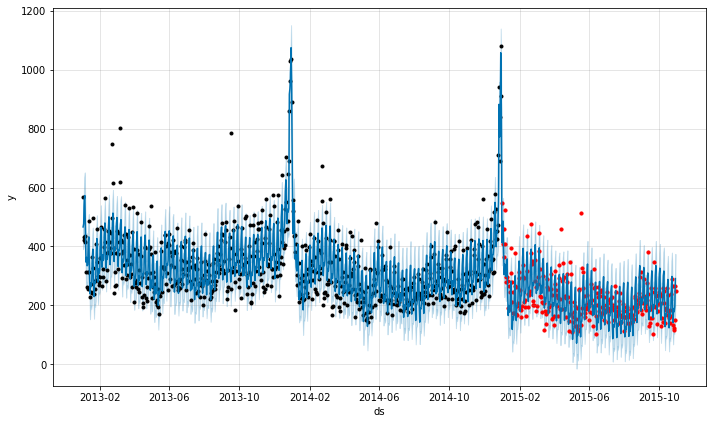

In [ ]:
# fitting model
model_final = Prophet(
    holidays=holiday, # holiday effect
    yearly_seasonality=True)
model_final.add_seasonality(name='monthly', period=30.5, fourier_order=5) # add monthly seasonality
model_final.fit(train) # only training set

# forecasting
future_final = model_final.make_future_dataframe(periods=303, freq='D') # 303 days (test size)
forecast_final = model_final.predict(future_final)

# visualize
fig = model_final.plot(forecast_final)
plt.scatter(x=test['ds'], y=test['y'], s=10, color='red')
plt.show()

## Evaluation Metrics

Based on the plot above, we can see that the model is capable in forecasting the actual future value. But for most part, we will need to quantify the error to be able to have a conclusive result. To quantify an error, we need to calculate the **difference between actual demand and the forecasted demand**. However, there are several metrics we can use to express the value. Some of them are:

- Root Mean Squared Error

<center>
$RMSE = \displaystyle{\sqrt{\frac{1}{n} \sum_{i=1}^{n}{(p_i - a_i)^2}}}$
</center>

- Root Mean Squared Logarithmic Error

<center>
$RMSLE = \displaystyle{\sqrt{\frac{1}{n} \sum_{i=1}^{n}{(log(p_i + 1) - log(a_i + 1))^2}}}$
</center>

Notation:

  - $n$: length of time series
  - $p_i$: predicted value at time $i$
  - $a_i$: actual value at time $i$

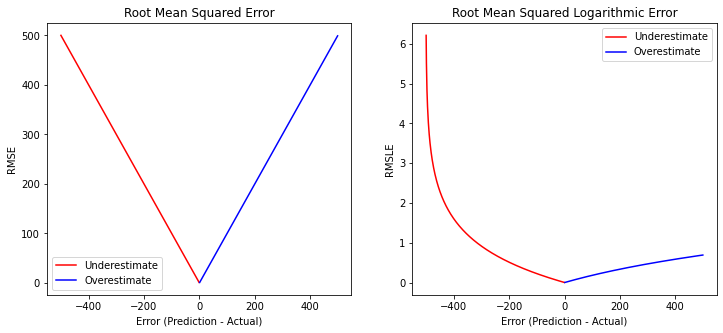

In [ ]:
#@title
# for illustration purposes only
## calculation
err = np.arange(-500, 500)
p = np.arange(0, 1000)
a = p - err
rmse_plot = np.power(err, 2) ** 0.5
rmsle_plot = np.power(np.log1p(p) - np.log1p(a), 2) ** 0.5

## visualization
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

for idx, (ax, y) in enumerate(zip(axes, [rmse_plot, rmsle_plot])):
  ax.plot(err[err < 0], y[err < 0], color = 'red', label = "Underestimate")
  ax.plot(err[err > 0], y[err > 0], color = 'blue', label = "Overestimate")
  ax.set_xlabel("Error (Prediction - Actual)")
  ax.set_ylabel(f"RMS{'L' if idx else ''}E")
  ax.set_title(f"Root Mean Squared {'Logarithmic ' if idx else ''}Error")
  ax.legend()

plt.show()

The main reason RMSLE is prefered over RMSE: It incurs a larger penalty for the underestimation of the actual value than the overestimation. This is useful for business cases where the underestimation of the target variable is not acceptable but overestimation can be tolerated.

In [ ]:
from sklearn.metrics import mean_squared_log_error
forecast_train = forecast_final[forecast_final['ds'] < cutoff]
train_rmsle = mean_squared_log_error(y_true=train['y'],
                                     y_pred=forecast_train['yhat']) ** 0.5
train_rmsle

0.18125248249390455

In [ ]:
forecast_test = forecast_final[forecast_final['ds'] >= cutoff]
test_rmsle = mean_squared_log_error(y_true=test['y'],
                                    y_pred=forecast_test['yhat']) ** 0.5
test_rmsle

0.36602550027367353

Any of the metrics can be used to benchmark a forecasting model, as long as we are consistent in using it. Other regression metrics can be seen on [Scikit Learn Documentation](https://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics)

## Expanding Window Cross Validation

Instead of only doing one time train-test split, we can do cross validation as shown below:

<center>
<img src="https://drive.google.com/uc?export=view&id=1HBE_VPCmJCn5QCt8ZIPIgqd3QPwUgS7R" width="400">
</center>

This cross validation procedure is called as **expanding window** and can be done automatically by using the `cross_validation()` method. There are three parameters to be specified:

- `initial`: the length of the initial training period
- `horizon`: forecast length
- `period`: spacing between cutoff dates

In [ ]:
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(model_total_revenue, initial='730 days', horizon='30 days', period='90 days')
df_cv

INFO:fbprophet:Making 4 forecasts with cutoffs between 2015-01-04 00:00:00 and 2015-10-01 00:00:00


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2015-01-05,453243.686249,342296.548994,569353.876163,357996.0,2015-01-04
1,2015-01-06,528839.864534,418366.914754,639894.410339,562368.0,2015-01-04
2,2015-01-07,400103.526338,294776.462893,522818.195595,290563.0,2015-01-04
3,2015-01-08,282273.692327,171705.429681,392245.872163,285423.0,2015-01-04
4,2015-01-09,255507.073608,138132.132796,361118.884303,232971.0,2015-01-04
...,...,...,...,...,...,...
115,2015-10-27,111576.408050,9698.675461,210230.470549,111851.0,2015-10-01
116,2015-10-28,91895.680477,2061.450834,191381.959167,180557.0,2015-10-01
117,2015-10-29,126869.389853,23673.865272,234469.652075,103456.0,2015-10-01
118,2015-10-30,237405.154426,131584.099477,337998.173118,204317.0,2015-10-01


The cross validation process above will be carried out for 4 folds, where at each fold a forecast will be made for the next 30 days (`horizon`) from the cutoff dates. Below is the illustration for each fold:

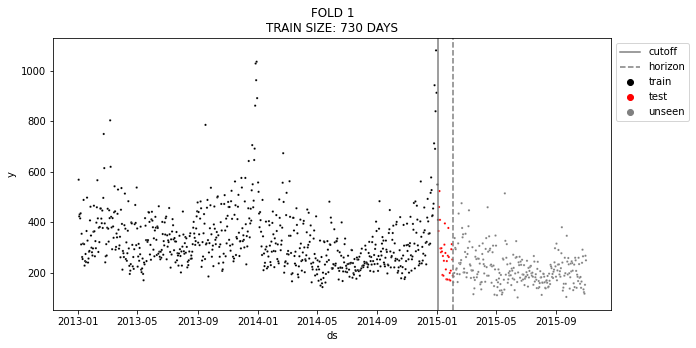

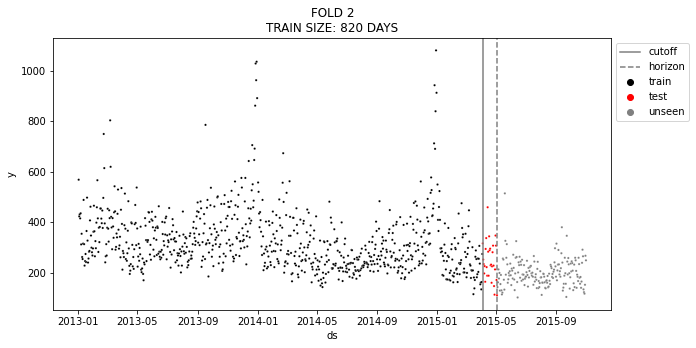

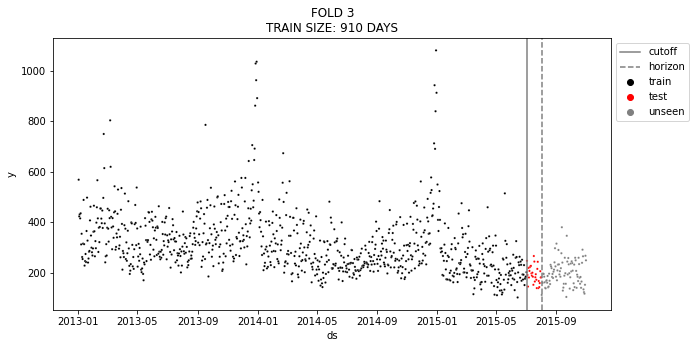

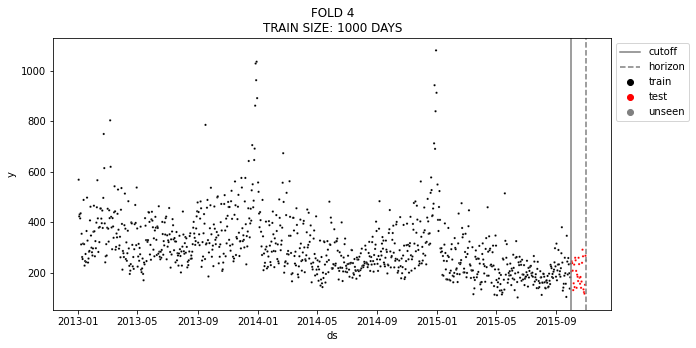

In [ ]:
#@title
# for illustration purposes only
df_copy = daily_total_qty[['ds', 'y']].copy()
df_cutoff_horizon = df_cv.groupby('cutoff')[['ds']].max()

for i, (cutoff, horizon) in enumerate(df_cutoff_horizon.iterrows()):
  horizon_cutoff = horizon['ds']

  df_copy['type'] = df_copy['ds'].apply(
      lambda date: 'train' if date < cutoff else 
                   'test' if date < horizon_cutoff else 'unseen')
  
  plt.figure(figsize=(10, 5))
  sns.scatterplot(x='ds', y='y', hue='type', s=5,
                  palette=['black', 'red', 'gray'],
                  data=df_copy)
  plt.axvline(x=cutoff, color='gray', label='cutoff')
  plt.axvline(x=horizon_cutoff, color='gray', ls='--', label='horizon')
  plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
  plt.title(f"FOLD {i+1}\nTRAIN SIZE: {df_copy['type'].value_counts()['train']} DAYS")
  plt.show()

Cross validation error metrics can be evaluated for each folds, here shown for RMSLE.

In [ ]:
cv_rmsle = df_cv.groupby('cutoff').apply(
    lambda x: mean_squared_log_error(y_true=x['y'],
                                     y_pred=x['yhat']) ** 0.5)
cv_rmsle

cutoff
2015-01-04    0.235920
2015-04-04    0.304658
2015-07-03    0.236829
2015-10-01    0.308821
dtype: float64

We can aggregate the metrics by using its mean. In other words, we are calculating the **mean of RMSLE** to represent the overall model performance.

In [ ]:
cv_rmsle.mean()

0.27155703183152

# Hyperparameter Tuning

In this section, we implement a **Grid search algorithm** for model tuning by using for-loop. It builds model for every combination from specified hyperparameters and then evaluate it. The goal is to choose a set of optimal hyperparameters which minimize the forecast error (in this case, smallest RMSLE).

💡 You can use the code template below, please change it as needed in the section marked by `TO DO`.


Click [here](https://facebook.github.io/prophet/docs/diagnostics.html#hyperparameter-tuning) for a list of recommended hyperparameters to be tuned.

In [ ]:
from tqdm import tqdm
import itertools

# Grid search parameters (TO DO: specify possible values)
param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1],
    'changepoint_range': [0.8, 0.95]
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmsles = []  # Store the RMSLEs for each params here

# Use cross validation to evaluate all parameters
for params in tqdm(all_params):
  # fitting model
  # (TO DO: change the data and add other components: seasonality, holiday, regressor)
  model = Prophet(**params,
                  holidays=holiday)
  model.fit(daily_total_qty)

  # Expanding window cross validation (TO DO: use different values)
  cv = cross_validation(model, initial='730 days', period='90 days', horizon='60 days',
                        parallel='processes')
  
  # Evaluation metrics: RMSLE
  rmsle = cv.groupby('cutoff').apply(
      lambda x: mean_squared_log_error(y_true=x['y'],
                                       y_pred=x['yhat']) ** 0.5)
  
  mean_rmsle = rmsle.mean()
  rmsles.append(mean_rmsle)

  0%|          | 0/6 [00:00<?, ?it/s]INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 3 forecasts with cutoffs between 2015-03-05 00:00:00 and 2015-09-01 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7faa211b2080>
 17%|█▋        | 1/6 [00:05<00:29,  5.92s/it]INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 3 forecasts with cutoffs between 2015-03-05 00:00:00 and 2015-09-01 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7faa211dc2b0>
 33%|███▎      | 2/6 [00:11<00:23,  5.91s/it]INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 3 forecasts with cutoffs between 2015-03-05 00:00:00 and 2015-09-01 00:00:00
INFO:fbprophet:Applying in parallel with

We can observe the error metrics for each hyperparameter combination, and sort by ascending:

In [ ]:
tuning_results = pd.DataFrame(all_params)
tuning_results['rmsle'] = rmsles
tuning_results.sort_values(by='rmsle')

,changepoint_prior_scale,changepoint_range,rmsle
5,0.100,0.95,0.264595
4,0.100,0.80,0.264672
3,0.010,0.95,0.265335
2,0.010,0.80,0.266934
0,0.001,0.80,0.268179
1,0.001,0.95,0.275176


Best hyperparameter combination can be extracted as follows:

In [ ]:
best_params = all_params[np.argmin(rmsles)]
best_params

{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.95}

Lastly, re-fit the model and use it for forecasting.

In [ ]:
model_best = Prophet(**best_params, holidays=holiday)
model_best.fit(daily_total_qty)
model_best

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Note: `**` is an operator for dictionary unpacking. It delivers key-value pairs in a dictionary into a function's arguments.

# [Optional] Error Diagnostics

Prophet has provide us several frequently used evaluation metrics by using `performance_metrics()`:

- Mean Squared Error (MSE)
- Root Mean Squared Error (RMSE)
- Mean Absolute Error (MAE)
- Mean Absolute Percentage Error (MAPE)
- Median Absolute Percentage Error (MDAPE)
- Coverage: Percentage of actual data that falls on the forecasted [uncertainty (confidence) interval](https://facebook.github.io/prophet/docs/uncertainty_intervals.html)

In [ ]:
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv, rolling_window=0)
df_p

,horizon,mse,rmse,mae,mape,mdape,coverage
0,1 days,3.994022e+09,63198.275661,52590.473722,0.219069,0.193591,1.00
1,2 days,3.029427e+09,55040.228983,48066.407744,0.278188,0.238097,1.00
2,3 days,3.688972e+09,60736.911716,47184.356624,0.206292,0.210830,0.75
3,4 days,1.881936e+09,43381.285624,37413.289169,0.264149,0.215639,1.00
4,5 days,3.054242e+09,55265.193585,47331.129171,0.383068,0.302298,1.00
5,6 days,2.000743e+09,44729.665907,42226.641914,0.197795,0.207520,1.00
6,7 days,1.199535e+09,34634.305123,26280.118399,0.133289,0.092500,1.00
7,8 days,1.232793e+09,35111.156633,33702.901470,0.203406,0.175338,1.00
8,9 days,1.699657e+09,41226.902300,34656.102004,0.198048,0.199360,1.00
9,10 days,1.878038e+10,137041.527486,98109.672365,0.330543,0.329390,0.75


Cross validation performance metrics can be visualized with `plot_cross_validation_metric`, here shown for RMSE.

- Dots show the root squared error (RSE) for each prediction in `df_cv`.
- The blue line shows the RMSE for each horizon.

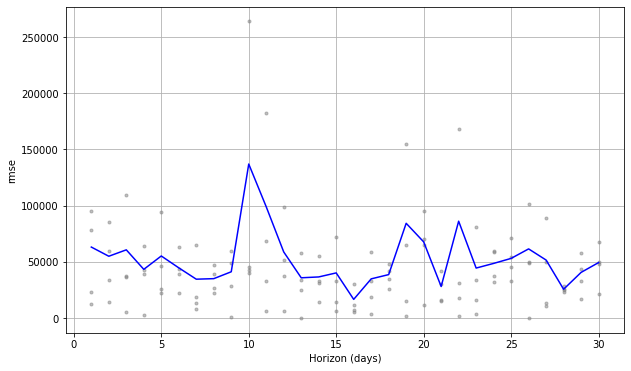

In [ ]:
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='rmse', rolling_window=0)

⚠️ Unfortunately, Prophet has not implement RMSLE metric in their library. Therefore, we have to calculate it manually according to its mathematical formula, or simply use `sklearn.metrics` module.

- Dots show the root squared logarithmic error (RSLE) for each prediction in `df_cv`.
- The blue line shows the RMSLE for each horizon.

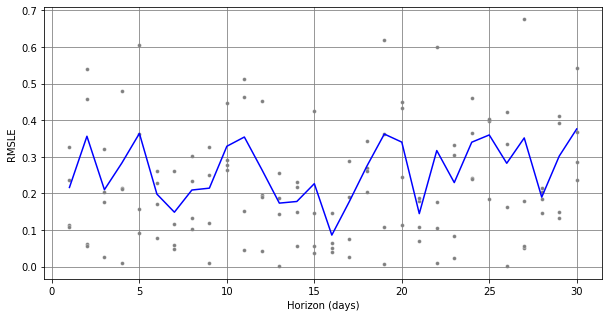

In [ ]:
# for illustration purposes only
## calculation
df_cv['horizon'] = (df_cv['ds'] - df_cv['cutoff']).dt.days
df_cv['sle'] = np.power((np.log1p(df_cv['yhat']) - np.log1p(df_cv['y'])), 2) # squared logarithmic error
df_cv['rsle'] = df_cv['sle'] ** 0.5
horizon_rmsle = df_cv.groupby('horizon')['sle'].apply(lambda x: x.mean() ** 0.5) # root mean

## visualization
plt.figure(figsize=(10, 5))
sns.scatterplot(x='horizon', y='rsle', 
                s=15, color='gray',
                data=df_cv)
plt.plot(horizon_rmsle.index, horizon_rmsle, color='blue')
plt.grid(b=True, which='major', color='gray', linestyle='-')
plt.xlabel('Horizon (days)')
plt.ylabel('RMSLE')
plt.show()

# References

Prophet related:

- [Prophet Documentation](https://facebook.github.io/prophet/docs/quick_start.html)
- [Paper: Forecasting at Scale](https://peerj.com/preprints/3190/)
- [Algoritma: Time Series Forecasting using `prophet` in R](https://business-forecasting.netlify.app/#5_time_series_forecasting_using_prophet)

Further reading (for R):

- [Textbook Forecasting: Principles and Practice](https://otexts.com/fpp2/)
- [Algotech: Multiple Seasonality Time Series](https://algotech.netlify.app/blog/multiple-seasonal/)
- [Algotech: Time Series LSTM (Neural Network)](https://algotech.netlify.app/blog/time-series-prediction-with-lstm/)
- [Algotech: Multiple Time Series Model](https://algotech.netlify.app/blog/purrr-operly-fitting-multiple-time-series-model/)

